# CNN
This is trained using accelerator GPU T4*2 on Kaggle

The dataset used for training and testing was downloaded from the LMS platform and uploaded to Kaggle manually. The folder structure is as follows:
```
2025_A2/
|- train/
|   |- img_000001.jpg
|   |- ...
|- test/
    |- img_005489.jpg
    |- ...
```

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.io import read_image, ImageReadMode

from sklearn.model_selection import train_test_split

## 1. Configuration

In [32]:
IMG_WIDTH = 48 # Target width for resizing images
IMG_HEIGHT = 48 # Target height for resizing images
IMG_CHANNELS = 3 # 3 for RGB
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = 43 # Number of road sign classes
LEARNING_RATE = 0.001
PATIENCE_EARLY_STOPPING = 10 # For EarlyStopping
PATIENCE_LR_SCHEDULER = 5  # For ReduceLROnPlateau

BASE_TRAIN_DIR = '/kaggle/input/25s1-comp30027-ml-a2/2025_A2/train/'
BASE_TEST_DIR = '/kaggle/input/25s1-comp30027-ml-a2/2025_A2/test/'
MODEL_SAVE_PATH = '/kaggle/working/pytorch_cnn_road_sign_model.pth'
SUBMISSION_SAVE_PATH = '/kaggle/working/submission_pytorch_cnn.csv'

# Check for GPU availability
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## 2. Load Images

In [33]:
class RoadSignDataset(Dataset):
    def __init__(self, dataframe, base_dir, transform=None, mode='train'):
        self.df = dataframe # DataFrame with image_path and ClassId (for train/val) or id (for test)
        self.base_dir = base_dir # Base directory where images are located (train/ or test/)
        self.transform = transform
        self.mode = mode # 'train', 'val', or 'test'

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
    
        img_relative_path = self.df.iloc[idx]['image_path'] # Construct full image path
        img_full_path = os.path.join(self.base_dir, img_relative_path)
    
        image = None
        try:
            image = read_image(img_full_path, mode=ImageReadMode.RGB)
        except Exception as e_torchvision:
            print(f"Torchvision read_image failed for {img_full_path}: {e_torchvision}. Falling back to PIL.")
            try:
                # Use PIL to load and convert image to RGB
                image_pil = Image.open(img_full_path).convert('RGB')
                image = np.array(image_pil) 
                image = torch.from_numpy(image.transpose((2, 0, 1))) 
            except Exception as e_pil:
                print(f"Critical error loading image {img_full_path} with PIL: {e_pil}")
                dummy_image_tensor = torch.zeros((IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH), dtype=torch.uint8)
                if self.mode == 'test':
                    sample_id = self.df.iloc[idx].get('id', f"error_id_{idx}")
                    # Ensure img_relative_path is defined even in error for consistent return signature
                    return dummy_image_tensor, sample_id, img_relative_path 
                else:
                    return dummy_image_tensor, -1 
    
        if self.transform:
            image = self.transform(image)
    
        if self.mode == 'test':
            sample_id = self.df.iloc[idx].get('id', f"error_id_{idx}") 
            return image, sample_id, img_relative_path
        else:
            label = int(self.df.iloc[idx]['ClassId'])
            return image, label

## 3. Image Transformations

In [34]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(), # Convert from uint8 tensor to PIL Image
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(), # Converts PIL image (H,W,C) in range [0,255] to (C,H,W) float tensor in range [0,1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize to [-1,1]
])

val_test_transforms = transforms.Compose([
    transforms.ToPILImage(), # Convert from uint8 tensor to PIL Image
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(), # Converts PIL image to float tensor in range [0,1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize to [-1,1]
])

## 4. Define CNN Model

In [35]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        dummy_input = torch.randn(1, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH)
        dummy_output = self.conv_layers(dummy_input)
        self.flattened_size = int(np.prod(dummy_output.size()[1:]))

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes) # Output layer, CrossEntropyLoss will apply softmax
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

## 5. Training and Validation Functions

In [36]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch_num):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch_num+1}/{EPOCHS} [Training]")
    for inputs, labels in progress_bar:
        # Filter out bad images (label == -1)
        valid_indices = labels != -1
        if not valid_indices.any():
            continue
        inputs, labels = inputs[valid_indices], labels[valid_indices]

        inputs, labels = inputs.to(device), labels.to(device).long() # Ensure labels are LongTensor

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
        
        progress_bar.set_postfix(loss=running_loss/total_samples, acc=correct_predictions.double()/total_samples)

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions.double() / total_samples if total_samples > 0 else 0
    return epoch_loss, epoch_acc

In [37]:
def validate_one_epoch(model, dataloader, criterion, device, epoch_num):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch_num+1}/{EPOCHS} [Validation]")
    with torch.no_grad():
        for inputs, labels in progress_bar:
            # Filter out bad images
            valid_indices = labels != -1
            if not valid_indices.any():
                continue
                
            inputs, labels = inputs[valid_indices], labels[valid_indices]
            inputs, labels = inputs.to(device), labels.to(device).long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
            progress_bar.set_postfix(loss=running_loss/total_samples, acc=correct_predictions.double()/total_samples)

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions.double() / total_samples if total_samples > 0 else 0
    return epoch_loss, epoch_acc

## 6. Main Training Loop

In [38]:
def run_training():
    print("\n--- Initializing Training ---")
    # Load dataset info
    train_val_df_info = pd.read_csv(os.path.join(BASE_TRAIN_DIR, 'train_metadata.csv'))
    if train_val_df_info is None or train_val_df_info.empty:
        print("Could not load training metadata. Exiting.")
        return

    # Split into training and validation sets
    train_df, val_df = train_test_split(
        train_val_df_info,
        test_size=0.2,
        random_state=42,
        stratify=train_val_df_info['ClassId']
    )
    print(f"Training set size: {len(train_df)}, Validation set size: {len(val_df)}")

    # Create Datasets and DataLoaders
    train_dataset = RoadSignDataset(train_df, BASE_TRAIN_DIR, transform=train_transforms, mode='train')
    val_dataset = RoadSignDataset(val_df, BASE_TRAIN_DIR, transform=val_test_transforms, mode='val')

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Initialize model, criterion, optimizer
    model = SimpleCNN(num_classes=NUM_CLASSES).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=PATIENCE_LR_SCHEDULER)

    best_val_accuracy = 0.0
    epochs_no_improve = 0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print("\n--- Starting Training Loop ---")
    start_time_total = time.time()
    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE, epoch)
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, DEVICE, epoch)
        epoch_duration = time.time() - epoch_start_time

        print(f"Epoch {epoch+1}/{EPOCHS}\n"
              f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}\n"
              f"- Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n"
              f"- LR: {optimizer.param_groups[0]['lr']:.1e}\n"
              f"- Duration: {epoch_duration:.2f}s")

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc.item() if torch.is_tensor(train_acc) else train_acc) # Ensure float for plotting
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item() if torch.is_tensor(val_acc) else val_acc) # Ensure float

        scheduler.step(val_loss) # ReduceLROnPlateau steps on validation loss

        if val_acc > best_val_accuracy:
            print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_acc:.4f}. Saving model...")
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"Validation accuracy did not improve. Current best: {best_val_accuracy:.4f}. Epochs without improvement: {epochs_no_improve}.")

        if epochs_no_improve >= PATIENCE_EARLY_STOPPING:
            print(f"Early stopping triggered after {PATIENCE_EARLY_STOPPING} epochs without improvement.")
            break
            
    total_training_time = time.time() - start_time_total
    print(f"\n--- Training Finished --- Total Time: {total_training_time // 60:.0f}m {total_training_time % 60:.0f}s")
    print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

    # Plot training history
    plt.figure(figsize=(6, 10))
    plt.subplot(2, 1, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()

## 7. Predict on Test Set

In [39]:
def predict_and_create_submission():
    print("\n--- Predicting on Test Set ---")

    # Load test metadata
    test_metadata_df = pd.read_csv(os.path.join(BASE_TEST_DIR, 'test_metadata.csv'))
    test_dataset = RoadSignDataset(test_metadata_df, BASE_TEST_DIR, transform=val_test_transforms, mode='test')
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count() // 2 or 1)

    # Load trained model
    print(f"Loading model from: {MODEL_SAVE_PATH}")
    model = SimpleCNN(num_classes=NUM_CLASSES).to(DEVICE)
    try:
        model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    except FileNotFoundError:
        print(f"ERROR: Model not found at {MODEL_SAVE_PATH}")
        return
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    model.eval()
    all_predictions, all_ids, all_paths = [], [], []

    # Make predictions
    with torch.no_grad():
        for inputs, ids, paths in tqdm(test_loader, desc="Predicting"):
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_predictions.extend(preds.cpu().numpy())
            all_ids.extend(ids.cpu().tolist() if torch.is_tensor(ids) else ids)
            all_paths.extend(paths)

    print(f"Predictions made: {len(all_predictions)}")

    # Map image paths to predictions
    path_to_pred = {path: pred for path, pred in zip(all_paths, all_predictions)}

    # Create submission
    test_metadata_df['id'] = test_metadata_df['id'].astype(str)
    final_preds = []
    final_ids = []

    for _, row in test_metadata_df.iterrows():
        img_id = str(row['id'])
        path = row['image_path']
        final_ids.append(img_id)
        final_preds.append(path_to_pred.get(path, 0))  # Default to class 0 if missing

    submission_df = pd.DataFrame({'id': final_ids, 'ClassId': final_preds})
    submission_df.to_csv(SUBMISSION_SAVE_PATH, index=False)

    print(f"Submission saved to {SUBMISSION_SAVE_PATH}")

## 8. Execution


--- Initializing Training ---
Training set size: 4390, Validation set size: 1098

--- Starting Training Loop ---


Epoch 1/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00,  9.63it/s, acc=tensor(0.3916, device='cuda:0', dtype=torch.float64), loss=2.02]


Epoch 1/50
- Train Loss: 2.9412, Train Acc: 0.2435
- Val Loss: 2.0180, Val Acc: 0.3916
- LR: 1.0e-03
- Duration: 9.93s
Validation accuracy improved from 0.0000 to 0.3916. Saving model...


Epoch 2/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 14.29it/s, acc=tensor(0.6849, device='cuda:0', dtype=torch.float64), loss=1.14]


Epoch 2/50
- Train Loss: 1.8132, Train Acc: 0.4809
- Val Loss: 1.1376, Val Acc: 0.6849
- LR: 1.0e-03
- Duration: 7.26s
Validation accuracy improved from 0.3916 to 0.6849. Saving model...


Epoch 3/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.80it/s, acc=tensor(0.7659, device='cuda:0', dtype=torch.float64), loss=0.808]


Epoch 3/50
- Train Loss: 1.1750, Train Acc: 0.6595
- Val Loss: 0.8076, Val Acc: 0.7659
- LR: 1.0e-03
- Duration: 7.32s
Validation accuracy improved from 0.6849 to 0.7659. Saving model...


Epoch 4/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.87it/s, acc=tensor(0.8670, device='cuda:0', dtype=torch.float64), loss=0.513]


Epoch 4/50
- Train Loss: 0.8115, Train Acc: 0.7749
- Val Loss: 0.5135, Val Acc: 0.8670
- LR: 1.0e-03
- Duration: 7.51s
Validation accuracy improved from 0.7659 to 0.8670. Saving model...


Epoch 5/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.79it/s, acc=tensor(0.8971, device='cuda:0', dtype=torch.float64), loss=0.401]


Epoch 5/50
- Train Loss: 0.5613, Train Acc: 0.8467
- Val Loss: 0.4012, Val Acc: 0.8971
- LR: 1.0e-03
- Duration: 7.35s
Validation accuracy improved from 0.8670 to 0.8971. Saving model...


Epoch 6/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.50it/s, acc=tensor(0.9308, device='cuda:0', dtype=torch.float64), loss=0.278]


Epoch 6/50
- Train Loss: 0.4160, Train Acc: 0.8854
- Val Loss: 0.2779, Val Acc: 0.9308
- LR: 1.0e-03
- Duration: 7.51s
Validation accuracy improved from 0.8971 to 0.9308. Saving model...


Epoch 7/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.71it/s, acc=tensor(0.9399, device='cuda:0', dtype=torch.float64), loss=0.206]


Epoch 7/50
- Train Loss: 0.3107, Train Acc: 0.9175
- Val Loss: 0.2060, Val Acc: 0.9399
- LR: 1.0e-03
- Duration: 7.23s
Validation accuracy improved from 0.9308 to 0.9399. Saving model...


Epoch 8/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.94it/s, acc=tensor(0.9627, device='cuda:0', dtype=torch.float64), loss=0.133]


Epoch 8/50
- Train Loss: 0.2681, Train Acc: 0.9241
- Val Loss: 0.1326, Val Acc: 0.9627
- LR: 1.0e-03
- Duration: 7.36s
Validation accuracy improved from 0.9399 to 0.9627. Saving model...


Epoch 9/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 14.46it/s, acc=tensor(0.9736, device='cuda:0', dtype=torch.float64), loss=0.0973]


Epoch 9/50
- Train Loss: 0.2331, Train Acc: 0.9396
- Val Loss: 0.0973, Val Acc: 0.9736
- LR: 1.0e-03
- Duration: 7.13s
Validation accuracy improved from 0.9627 to 0.9736. Saving model...


Epoch 10/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.51it/s, acc=tensor(0.9718, device='cuda:0', dtype=torch.float64), loss=0.0838]


Epoch 10/50
- Train Loss: 0.1998, Train Acc: 0.9456
- Val Loss: 0.0838, Val Acc: 0.9718
- LR: 1.0e-03
- Duration: 7.54s
Validation accuracy did not improve. Current best: 0.9736. Epochs without improvement: 1.


Epoch 11/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.75it/s, acc=tensor(0.9772, device='cuda:0', dtype=torch.float64), loss=0.142]


Epoch 11/50
- Train Loss: 0.1780, Train Acc: 0.9494
- Val Loss: 0.1420, Val Acc: 0.9772
- LR: 1.0e-03
- Duration: 7.58s
Validation accuracy improved from 0.9736 to 0.9772. Saving model...


Epoch 12/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.47it/s, acc=tensor(0.9645, device='cuda:0', dtype=torch.float64), loss=0.243]


Epoch 12/50
- Train Loss: 0.1647, Train Acc: 0.9549
- Val Loss: 0.2430, Val Acc: 0.9645
- LR: 1.0e-03
- Duration: 7.57s
Validation accuracy did not improve. Current best: 0.9772. Epochs without improvement: 1.


Epoch 13/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 12.52it/s, acc=tensor(0.9608, device='cuda:0', dtype=torch.float64), loss=0.246]


Epoch 13/50
- Train Loss: 0.1535, Train Acc: 0.9581
- Val Loss: 0.2462, Val Acc: 0.9608
- LR: 1.0e-03
- Duration: 7.75s
Validation accuracy did not improve. Current best: 0.9772. Epochs without improvement: 2.


Epoch 14/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.56it/s, acc=tensor(0.9800, device='cuda:0', dtype=torch.float64), loss=0.0693]


Epoch 14/50
- Train Loss: 0.1486, Train Acc: 0.9617
- Val Loss: 0.0693, Val Acc: 0.9800
- LR: 1.0e-03
- Duration: 7.45s
Validation accuracy improved from 0.9772 to 0.9800. Saving model...


Epoch 15/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.93it/s, acc=tensor(0.9772, device='cuda:0', dtype=torch.float64), loss=0.0787]


Epoch 15/50
- Train Loss: 0.1113, Train Acc: 0.9688
- Val Loss: 0.0787, Val Acc: 0.9772
- LR: 1.0e-03
- Duration: 7.27s
Validation accuracy did not improve. Current best: 0.9800. Epochs without improvement: 1.


Epoch 16/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.38it/s, acc=tensor(0.9791, device='cuda:0', dtype=torch.float64), loss=0.0668]


Epoch 16/50
- Train Loss: 0.1380, Train Acc: 0.9606
- Val Loss: 0.0668, Val Acc: 0.9791
- LR: 1.0e-03
- Duration: 7.51s
Validation accuracy did not improve. Current best: 0.9800. Epochs without improvement: 2.


Epoch 17/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.96it/s, acc=tensor(0.9781, device='cuda:0', dtype=torch.float64), loss=0.0658]


Epoch 17/50
- Train Loss: 0.0985, Train Acc: 0.9731
- Val Loss: 0.0658, Val Acc: 0.9781
- LR: 1.0e-03
- Duration: 7.31s
Validation accuracy did not improve. Current best: 0.9800. Epochs without improvement: 3.


Epoch 18/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 14.25it/s, acc=tensor(0.9736, device='cuda:0', dtype=torch.float64), loss=0.12] 


Epoch 18/50
- Train Loss: 0.0988, Train Acc: 0.9743
- Val Loss: 0.1205, Val Acc: 0.9736
- LR: 1.0e-03
- Duration: 7.21s
Validation accuracy did not improve. Current best: 0.9800. Epochs without improvement: 4.


Epoch 19/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.08it/s, acc=tensor(0.9900, device='cuda:0', dtype=torch.float64), loss=0.0327]


Epoch 19/50
- Train Loss: 0.0876, Train Acc: 0.9765
- Val Loss: 0.0327, Val Acc: 0.9900
- LR: 1.0e-03
- Duration: 7.29s
Validation accuracy improved from 0.9800 to 0.9900. Saving model...


Epoch 20/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 14.41it/s, acc=tensor(0.9854, device='cuda:0', dtype=torch.float64), loss=0.0595]


Epoch 20/50
- Train Loss: 0.0751, Train Acc: 0.9781
- Val Loss: 0.0595, Val Acc: 0.9854
- LR: 1.0e-03
- Duration: 7.29s
Validation accuracy did not improve. Current best: 0.9900. Epochs without improvement: 1.


Epoch 21/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 14.22it/s, acc=tensor(0.9727, device='cuda:0', dtype=torch.float64), loss=0.104]


Epoch 21/50
- Train Loss: 0.0927, Train Acc: 0.9713
- Val Loss: 0.1045, Val Acc: 0.9727
- LR: 1.0e-03
- Duration: 7.33s
Validation accuracy did not improve. Current best: 0.9900. Epochs without improvement: 2.


Epoch 22/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 14.26it/s, acc=tensor(0.9536, device='cuda:0', dtype=torch.float64), loss=0.165]


Epoch 22/50
- Train Loss: 0.0805, Train Acc: 0.9759
- Val Loss: 0.1653, Val Acc: 0.9536
- LR: 1.0e-03
- Duration: 7.17s
Validation accuracy did not improve. Current best: 0.9900. Epochs without improvement: 3.


Epoch 23/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 14.61it/s, acc=tensor(0.9882, device='cuda:0', dtype=torch.float64), loss=0.0947]


Epoch 23/50
- Train Loss: 0.0767, Train Acc: 0.9774
- Val Loss: 0.0947, Val Acc: 0.9882
- LR: 1.0e-03
- Duration: 7.25s
Validation accuracy did not improve. Current best: 0.9900. Epochs without improvement: 4.


Epoch 24/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 14.07it/s, acc=tensor(0.9699, device='cuda:0', dtype=torch.float64), loss=0.0899]


Epoch 24/50
- Train Loss: 0.0837, Train Acc: 0.9786
- Val Loss: 0.0899, Val Acc: 0.9699
- LR: 1.0e-03
- Duration: 7.33s
Validation accuracy did not improve. Current best: 0.9900. Epochs without improvement: 5.


Epoch 25/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 14.28it/s, acc=tensor(0.9800, device='cuda:0', dtype=torch.float64), loss=0.0718]


Epoch 25/50
- Train Loss: 0.0710, Train Acc: 0.9800
- Val Loss: 0.0718, Val Acc: 0.9800
- LR: 1.0e-03
- Duration: 7.30s
Validation accuracy did not improve. Current best: 0.9900. Epochs without improvement: 6.


Epoch 26/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.92it/s, acc=tensor(0.9936, device='cuda:0', dtype=torch.float64), loss=0.0267]


Epoch 26/50
- Train Loss: 0.0554, Train Acc: 0.9859
- Val Loss: 0.0267, Val Acc: 0.9936
- LR: 2.0e-04
- Duration: 7.28s
Validation accuracy improved from 0.9900 to 0.9936. Saving model...


Epoch 27/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.71it/s, acc=tensor(0.9918, device='cuda:0', dtype=torch.float64), loss=0.0298]


Epoch 27/50
- Train Loss: 0.0415, Train Acc: 0.9868
- Val Loss: 0.0298, Val Acc: 0.9918
- LR: 2.0e-04
- Duration: 7.18s
Validation accuracy did not improve. Current best: 0.9936. Epochs without improvement: 1.


Epoch 28/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.20it/s, acc=tensor(0.9954, device='cuda:0', dtype=torch.float64), loss=0.0246]


Epoch 28/50
- Train Loss: 0.0373, Train Acc: 0.9913
- Val Loss: 0.0246, Val Acc: 0.9954
- LR: 2.0e-04
- Duration: 7.52s
Validation accuracy improved from 0.9936 to 0.9954. Saving model...


Epoch 29/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.47it/s, acc=tensor(0.9936, device='cuda:0', dtype=torch.float64), loss=0.0296]


Epoch 29/50
- Train Loss: 0.0363, Train Acc: 0.9923
- Val Loss: 0.0296, Val Acc: 0.9936
- LR: 2.0e-04
- Duration: 7.36s
Validation accuracy did not improve. Current best: 0.9954. Epochs without improvement: 1.


Epoch 30/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.56it/s, acc=tensor(0.9927, device='cuda:0', dtype=torch.float64), loss=0.0236]


Epoch 30/50
- Train Loss: 0.0285, Train Acc: 0.9936
- Val Loss: 0.0236, Val Acc: 0.9927
- LR: 2.0e-04
- Duration: 7.74s
Validation accuracy did not improve. Current best: 0.9954. Epochs without improvement: 2.


Epoch 31/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.88it/s, acc=tensor(0.9936, device='cuda:0', dtype=torch.float64), loss=0.0412]


Epoch 31/50
- Train Loss: 0.0272, Train Acc: 0.9923
- Val Loss: 0.0412, Val Acc: 0.9936
- LR: 2.0e-04
- Duration: 7.40s
Validation accuracy did not improve. Current best: 0.9954. Epochs without improvement: 3.


Epoch 32/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 14.52it/s, acc=tensor(0.9945, device='cuda:0', dtype=torch.float64), loss=0.0287]


Epoch 32/50
- Train Loss: 0.0311, Train Acc: 0.9913
- Val Loss: 0.0287, Val Acc: 0.9945
- LR: 2.0e-04
- Duration: 7.17s
Validation accuracy did not improve. Current best: 0.9954. Epochs without improvement: 4.


Epoch 33/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 14.77it/s, acc=tensor(0.9954, device='cuda:0', dtype=torch.float64), loss=0.0239]


Epoch 33/50
- Train Loss: 0.0267, Train Acc: 0.9923
- Val Loss: 0.0239, Val Acc: 0.9954
- LR: 2.0e-04
- Duration: 7.16s
Validation accuracy did not improve. Current best: 0.9954. Epochs without improvement: 5.


Epoch 34/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 13.89it/s, acc=tensor(0.9918, device='cuda:0', dtype=torch.float64), loss=0.0269]


Epoch 34/50
- Train Loss: 0.0212, Train Acc: 0.9964
- Val Loss: 0.0269, Val Acc: 0.9918
- LR: 2.0e-04
- Duration: 7.08s
Validation accuracy did not improve. Current best: 0.9954. Epochs without improvement: 6.


Epoch 35/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 14.32it/s, acc=tensor(0.9945, device='cuda:0', dtype=torch.float64), loss=0.0215]


Epoch 35/50
- Train Loss: 0.0281, Train Acc: 0.9929
- Val Loss: 0.0215, Val Acc: 0.9945
- LR: 2.0e-04
- Duration: 7.13s
Validation accuracy did not improve. Current best: 0.9954. Epochs without improvement: 7.


Epoch 36/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 14.54it/s, acc=tensor(0.9945, device='cuda:0', dtype=torch.float64), loss=0.0205]


Epoch 36/50
- Train Loss: 0.0209, Train Acc: 0.9954
- Val Loss: 0.0205, Val Acc: 0.9945
- LR: 2.0e-04
- Duration: 7.21s
Validation accuracy did not improve. Current best: 0.9954. Epochs without improvement: 8.


Epoch 37/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 14.13it/s, acc=tensor(0.9945, device='cuda:0', dtype=torch.float64), loss=0.0221]


Epoch 37/50
- Train Loss: 0.0217, Train Acc: 0.9950
- Val Loss: 0.0221, Val Acc: 0.9945
- LR: 2.0e-04
- Duration: 7.14s
Validation accuracy did not improve. Current best: 0.9954. Epochs without improvement: 9.


Epoch 38/50 [Validation]: 100%|██████████| 18/18 [00:01<00:00, 14.05it/s, acc=tensor(0.9945, device='cuda:0', dtype=torch.float64), loss=0.0263]


Epoch 38/50
- Train Loss: 0.0193, Train Acc: 0.9954
- Val Loss: 0.0263, Val Acc: 0.9945
- LR: 2.0e-04
- Duration: 7.14s
Validation accuracy did not improve. Current best: 0.9954. Epochs without improvement: 10.
Early stopping triggered after 10 epochs without improvement.

--- Training Finished --- Total Time: 4m 42s
Best Validation Accuracy: 0.9954

--- Predicting on Test Set ---
Loading model from: /kaggle/working/pytorch_cnn_road_sign_model.pth


Predicting: 100%|██████████| 37/37 [00:04<00:00,  8.06it/s]


Predictions made: 2353
Submission saved to /kaggle/working/submission_pytorch_cnn.csv


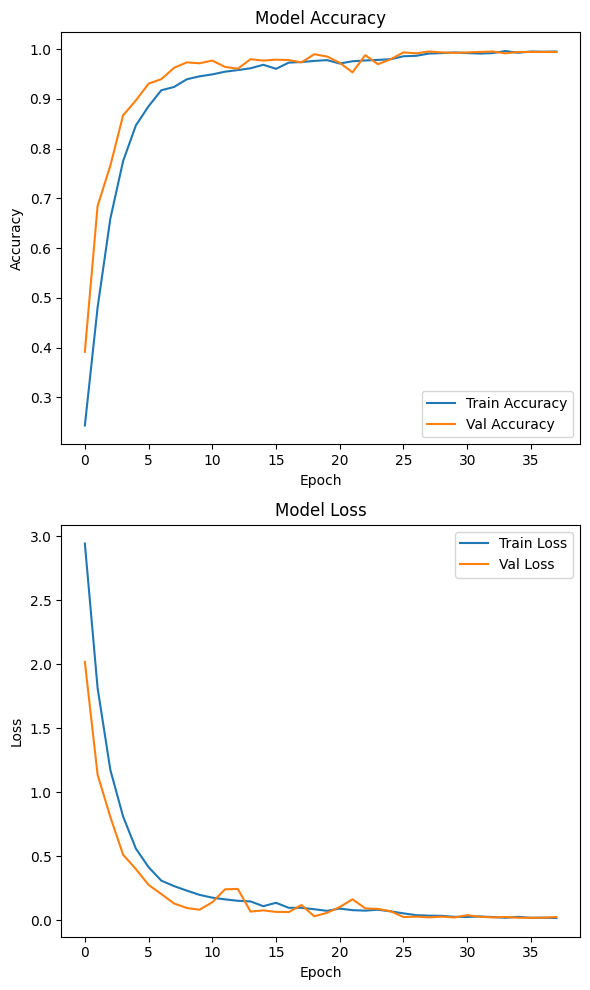

In [40]:
run_training()
predict_and_create_submission()